In [1]:
%pip install python-docx -q
%pip install pymupdf -q
%pip install sentence-transformers -q
%pip install faiss-cpu -q
%pip install transformers -q
%pip install accelerate  -q
%pip install bitsandbytes -q
%pip install pandas -q
%pip install matplotlib -q
%pip install langchain -q


%pip install huggingface_hub
# %pip install ipywidgets
# %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.4 MB/s eta 0:00:00


In [2]:
import re
import fitz
import pandas as pd
import matplotlib.pyplot as plt
from docx import Document
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util, CrossEncoder
import faiss
import torch
import numpy as np
from google.colab import files

In [3]:
def extract_text_from_docx(file_path):
    doc = Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    for table in doc.tables:
        for row in table.rows:
            for cell in row.cells:
                full_text.append(cell.text)
    return '\n'.join(full_text)

def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    full_text = []
    for page in doc:
        full_text.append(page.get_text())
    return '\n'.join(full_text)

uploaded = files.upload()

docx_text = extract_text_from_docx('/content/DICIONARIO_DE_DADOS.docx')
pdf_text = extract_text_from_pdf('/content/doencas_respiratorias_cronicas.pdf')
full_text = docx_text + "\n\n" + pdf_text

qa_pairs = {
    "Dicionário de Dados": {
        "Qual o nome da tabela LFCES004 no banco de produção federal?": "TB_ESTABELECIMENTO",
        "Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?": "Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.)",
        "Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?": "1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião"
    },
    "Doenças Respiratórias Crônicas": {
        "Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?": "Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",
        "Qual é a definição clássica de sintomático respiratório?": "É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",
        "Como a tosse pode ser classificada?": "Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas."
    }
}

Saving DICIONARIO_DE_DADOS.docx to DICIONARIO_DE_DADOS.docx
Saving doencas_respiratorias_cronicas.pdf to doencas_respiratorias_cronicas.pdf


In [4]:
embedding_model_for_eval = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def evaluate_and_format_results(results):
    evaluations = []
    for r in results:
        model_ans = r["Resposta"]
        correct_ans = r["Resposta Esperada"]

        if not model_ans:
            eval_manual = "❌"
        elif model_ans.lower().strip() == correct_ans.lower().strip():
            eval_manual = "✔️"
        elif model_ans.lower().strip() in correct_ans.lower().strip() or correct_ans.lower().strip() in model_ans.lower().strip():
            eval_manual = "➖"
        else:
            eval_manual = "❌"

        emb1 = embedding_model_for_eval.encode(model_ans, convert_to_tensor=True)
        emb2 = embedding_model_for_eval.encode(correct_ans, convert_to_tensor=True)
        similarity = util.cos_sim(emb1, emb2).item()

        evaluations.append({
            "Modelo": r["Modelo"],
            "Documento": r["Documento"],
            "Pergunta": r["Pergunta"],
            "Resposta": model_ans,
            "Resposta Esperada": correct_ans,
            "Avaliação": eval_manual,
            "Similaridade": round(similarity, 4),
            "Confiança": r.get("Confiança", "N/A")
        })
    return pd.DataFrame(evaluations)

def display_evaluation(df, title):
    print(f"\n--- {title} ---")

    styled_df = df.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
    display(styled_df)

    comparativo = df.groupby(["Modelo", "Avaliação"]).size().unstack(fill_value=0)

    colunas_ordenadas = [col for col in ["✔️", "➖", "❌"] if col in comparativo.columns]
    comparativo = comparativo[colunas_ordenadas]

    cores = {"✔️": "green", "➖": "orange", "❌": "red"}
    legenda_map = {"✔️": "Correta", "➖": "Parcialmente Correta", "❌": "Incorreta"}

    cores_usadas = [cores[col] for col in comparativo.columns]

    ax = comparativo.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 7),
        color=cores_usadas,
        edgecolor='black'
    )

    handles, labels = ax.get_legend_handles_labels()

    new_labels = [legenda_map.get(lbl, lbl) for lbl in labels]

    ax.legend(handles, new_labels, title="Avaliação")

    plt.title(title, fontsize=16)
    plt.xlabel("Modelo", fontsize=12)
    plt.ylabel("Quantidade de Respostas", fontsize=12)
    plt.xticks(rotation=0, ha='center')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Experimento 1: Modelos fracos com contexto completo

Rodando experimento 1 com modelo: deepset/roberta-base-squad2


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Rodando experimento 1 com modelo: distilbert-base-cased-distilled-squad


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cuda:0


Rodando experimento 1 com modelo: timpal0l/mdeberta-v3-base-squad2


config.json:   0%|          | 0.00/879 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Device set to use cuda:0



--- Experimento 1: Modelos fracos com contexto completo ---


,Modelo,Documento,Pergunta,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
0,roberta-base-squad2,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,Yes,TB_ESTABELECIMENTO,❌,0.065900,0.051600
1,roberta-base-squad2,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",Yes,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.017400,0.047600
2,roberta-base-squad2,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",Bairro,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.190400,0.098100
3,roberta-base-squad2,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,Symbicort,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.162800,0.044100
4,roberta-base-squad2,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,clínico,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.357900,0.121800
5,roberta-base-squad2,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,psicogênica,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,❌,0.045700,0.179400
6,distilbert-base-cased-distilled-squad,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,Ensinos F – Hosp,TB_ESTABELECIMENTO,❌,0.205600,0.480100
7,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",Ensinos F – Hosp,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.359600,0.669500
8,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",Ensinos F – Hosp,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.170900,0.581900
9,distilbert-base-cased-distilled-squad,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,MDI- HFA,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.039200,0.072700


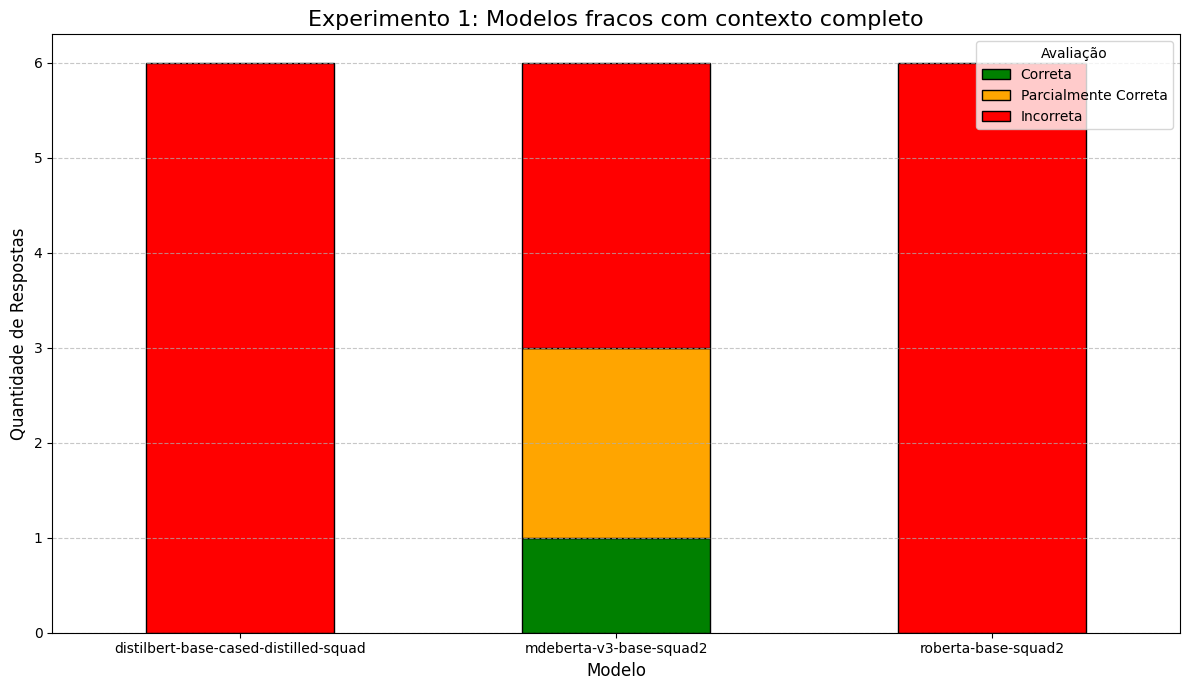

In [5]:
def split_context(text, max_len=1500):
    sentences = text.split('. ')
    blocks, current_block = [], ""
    for s in sentences:
        if len(current_block) + len(s) < max_len:
            current_block += s + ". "
        else:
            blocks.append(current_block.strip())
            current_block = s + ". "
    if current_block:
        blocks.append(current_block.strip())
    return blocks

model_names_exp1 = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "timpal0l/mdeberta-v3-base-squad2"
]

results_exp1 = []
document_map = {
    "Dicionário de Dados": docx_text,
    "Doenças Respiratórias Crônicas": pdf_text
}

for model_name in model_names_exp1:
    print(f"Rodando experimento 1 com modelo: {model_name}")
    qa_pipeline = pipeline("question-answering", model=model_name, tokenizer=model_name, device=0 if torch.cuda.is_available() else -1)

    for doc_name, questions in qa_pairs.items():
        context = document_map[doc_name]
        context_blocks = split_context(context)

        for question, correct_answer in questions.items():
            best_answer = {"answer": "", "score": 0.0}
            for block in context_blocks:
                if not block: continue
                try:
                    result = qa_pipeline(question=question, context=block)
                    if result["score"] > best_answer["score"]:
                        best_answer = result
                except Exception as e:
                    print(f"Error processing block: {e}")
                    continue

            results_exp1.append({
                "Modelo": model_name.split('/')[-1],
                "Documento": doc_name,
                "Pergunta": question,
                "Resposta": best_answer["answer"],
                "Resposta Esperada": correct_answer,
                "Confiança": round(best_answer["score"], 4)
            })

df_exp1 = evaluate_and_format_results(results_exp1)
display_evaluation(df_exp1, "Experimento 1: Modelos fracos com contexto completo")

# Experimento 2: Modelos fracos com RAG (Retrieval Augmented Generation)

Iniciando componentes do RAG...
Criando embeddings e index FAISS...


Batches:   0%|          | 0/21 [00:00<?, ?it/s]

index Faiss criado com sucesso.
Rodando experimento 2 com modelo: deepset/roberta-base-squad2


Device set to use cuda:0


Rodando experimento 2 com modelo: distilbert-base-cased-distilled-squad


Device set to use cuda:0


Rodando experimento 2 com modelo: timpal0l/mdeberta-v3-base-squad2


Device set to use cuda:0



--- Experimento 2: RAG com modelos fracos ---


,Modelo,Documento,Pergunta,Resposta,Resposta Esperada,Avaliação,Similaridade,Confiança
0,roberta-base-squad2,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,pela Portaria GM/MS n° 2.577,TB_ESTABELECIMENTO,❌,0.235100,0.001200
1,roberta-base-squad2,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),➖,0.038000,0.014200
2,roberta-base-squad2,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",TA,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",➖,0.107800,0.055500
3,roberta-base-squad2,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,superiores,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.039000,0.007300
4,roberta-base-squad2,Doenças Respiratórias Crônicas,Qual é a definição clássica de sintomático respiratório?,Cor pulmonale,"É o indivíduo que apresenta tosse, associada ou não a outra alteração respiratória, por algumas semanas.",❌,0.274700,0.072500
5,roberta-base-squad2,Doenças Respiratórias Crônicas,Como a tosse pode ser classificada?,crônica,Em aguda até três semanas de duração; subaguda de três a oito semanas; e crônica se superior a oito semanas.,➖,0.337800,0.241800
6,distilbert-base-cased-distilled-squad,Dicionário de Dados,Qual o nome da tabela LFCES004 no banco de produção federal?,Ensinos F – Hosp,TB_ESTABELECIMENTO,❌,0.205600,0.480100
7,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Na tabela RL_ESTAB_COMPLEMENTAR, o que representa o campo QTDE_SUS?",NULL Tipo de Categoria,Quantidade de Leitos Disponíveis para o SUS.( Para os Estabelecimentos vinculados ao SUS.),❌,0.296100,0.001000
8,distilbert-base-cased-distilled-squad,Dicionário de Dados,"Quais são os domínios do campo INDGESTOR, da tabela FCESGEST?",NULL Último Usuário que atualizou,"1 – Secretaria Estadual, 2 – Região de Saúde, 3 – Secretaria Municipal Não Pleno, 4 – Módulo Assistencial, 5 – Distrito Sanitário, 6 – DataSus, 7 – 5éc. Municipal Pleno, 8 – Capital, 9 – Microrregião",❌,0.257000,0.000400
9,distilbert-base-cased-distilled-squad,Doenças Respiratórias Crônicas,Quais são os principais fatores de risco preveníveis para doenças respiratórias crônicas (DRC)?,quando possível,"Tabagismo, poluição ambiental, alérgenos, agentes ocupacionais, pneumonia, bronquiolite e tuberculose.",❌,0.276200,0.264900


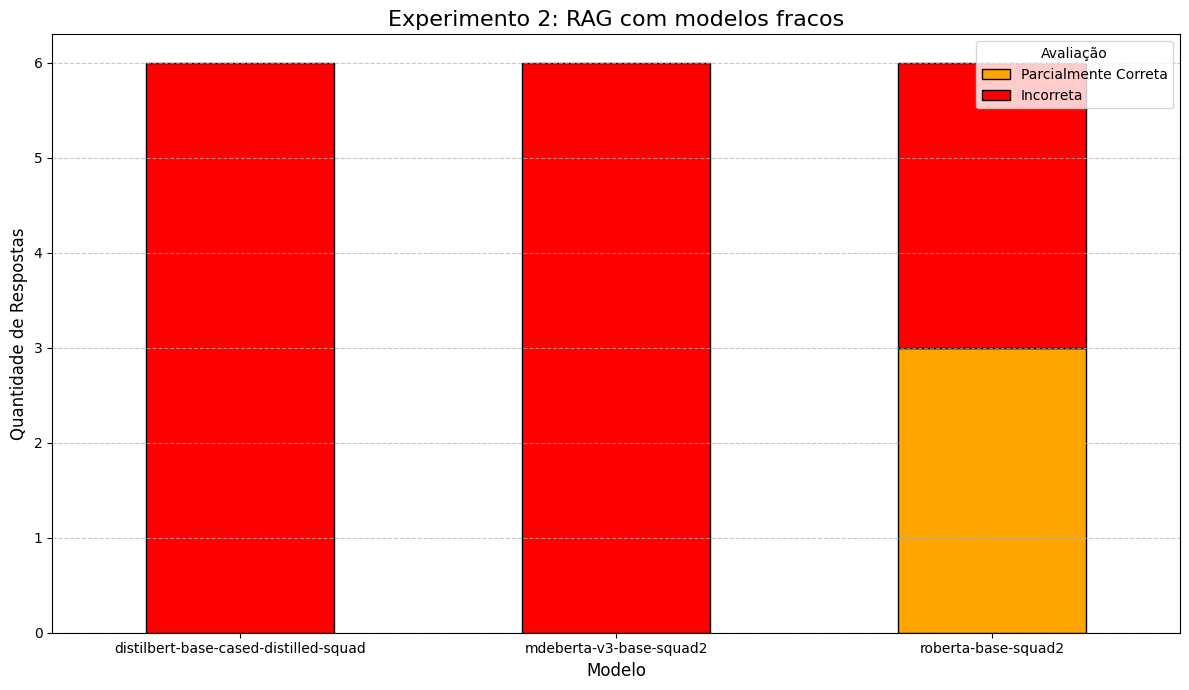

In [8]:
print("Iniciando componentes do RAG...")
# Escolhido por ser melhor que o usado para avaliação
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
text_chunks = split_context(full_text, max_len=512)

print("Criando embeddings e index FAISS...")
embeddings = embedding_model.encode(text_chunks, convert_to_tensor=True, show_progress_bar=True)
embeddings_cpu = embeddings.cpu().numpy()
faiss.normalize_L2(embeddings_cpu)

index = faiss.IndexFlatIP(embeddings_cpu.shape[1])
index.add(embeddings_cpu)
print("index Faiss criado com sucesso.")

def get_rag_answer(question, qa_pipeline, top_k=5):
    query_embedding = embedding_model.encode([question]).astype('float32')
    faiss.normalize_L2(query_embedding)

    _, indices = index.search(query_embedding, top_k)
    relevant_contexts = [text_chunks[i] for i in indices[0]]

    best_answer = {"answer": "", "score": 0.0}
    for context in relevant_contexts:
        if not context.strip(): continue
        result = qa_pipeline(question=question, context=context)
        if result["score"] > best_answer["score"]:
            best_answer = result

    return best_answer

results_exp2 = []
model_names_exp2 = [
    "deepset/roberta-base-squad2",
    "distilbert-base-cased-distilled-squad",
    "timpal0l/mdeberta-v3-base-squad2"
]

for model_name in model_names_exp2:
    print(f"Rodando experimento 2 com modelo: {model_name}")
    qa_pipeline = pipeline("question-answering", model=model_name, tokenizer=model_name, device=0 if torch.cuda.is_available() else -1)

    for doc_name, questions in qa_pairs.items():
        for question, correct_answer in questions.items():
            rag_result = get_rag_answer(question, qa_pipeline)
            results_exp2.append({
                "Modelo": model_name.split('/')[-1],
                "Documento": doc_name,
                "Pergunta": question,
                "Resposta": rag_result["answer"],
                "Resposta Esperada": correct_answer,
                "Confiança": round(rag_result["score"], 4)
            })

df_exp2 = evaluate_and_format_results(results_exp2)
display_evaluation(df_exp2, "Experimento 2: RAG com modelos fracos")

# Experimento 3: RAG com modelos mais poderosos


Rodando experimento 3 com modelo google/gemma-2b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Rodando experimento 3 com modelo meta-llama/Llama-3.2-1B-Instruct...

Rodando experimento 3 com modelo meta-llama/Llama-3.2-3B-Instruct...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


--- Experimento 3: RAG com LLMs ---


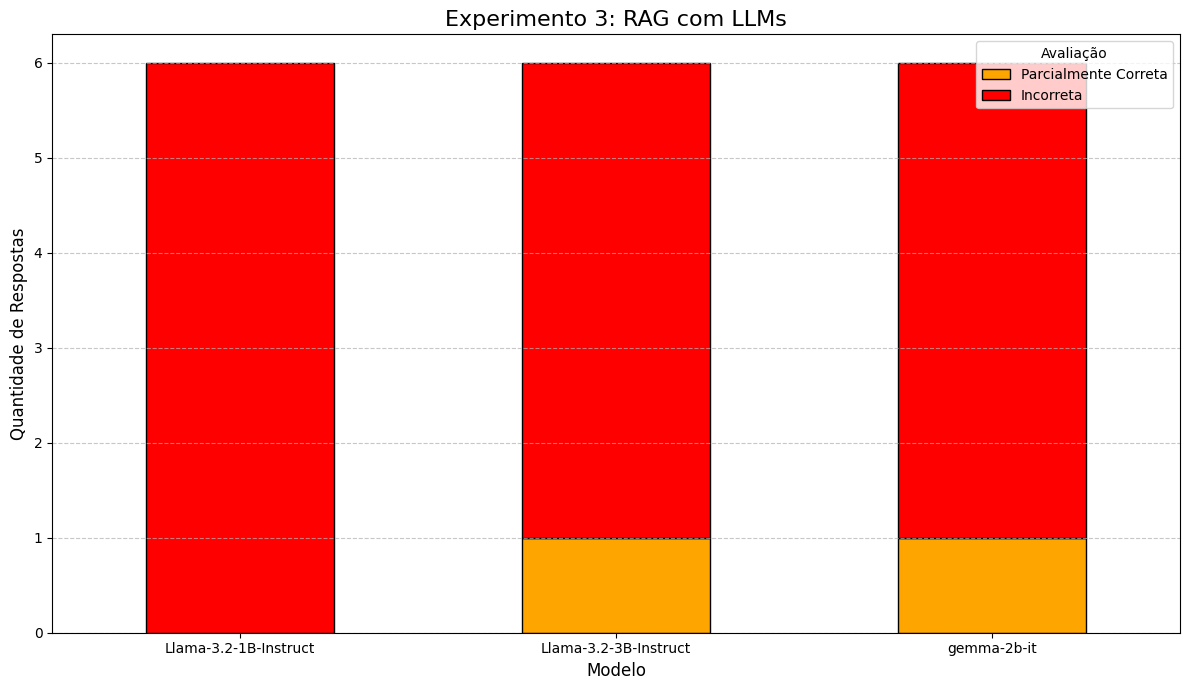

In [9]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
llm_names = ["google/gemma-2b-it", "meta-llama/Llama-3.2-1B-Instruct","meta-llama/Llama-3.2-3B-Instruct"]

class SimpleRAG:
    def __init__(self, embedding_model, cross_encoder, faiss_index, text_chunks):
        self.embedding_model = embedding_model
        self.cross_encoder = cross_encoder
        self.index = faiss_index
        self.text_chunks = text_chunks

    def get_relevant_context(self, question, top_k_initial=10, top_k_final=3):
        query_embedding = self.embedding_model.encode([question]).astype('float32')
        faiss.normalize_L2(query_embedding)
        _, indices = self.index.search(query_embedding, top_k_initial)
        initial_docs = [self.text_chunks[i] for i in indices[0]]

        pairs = [[question, doc] for doc in initial_docs]
        scores = self.cross_encoder.predict(pairs)
        doc_scores = sorted(zip(initial_docs, scores), key=lambda x: x[1], reverse=True)
        reranked_docs = [doc for doc, score in doc_scores[:top_k_final]]

        return "\n\n".join(reranked_docs)

def answer_single_question(question, context, llm_name):
    bnb_config = BitsAndBytesConfig(load_in_8bit=True)
    tokenizer = AutoTokenizer.from_pretrained(llm_name)
    model = AutoModelForCausalLM.from_pretrained(
        llm_name,
        quantization_config=bnb_config,
        device_map="auto"
    )

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    prompt = f"""Based strictly on the context below, answer the question. If the answer is not in the context, say so.

Context:
{context}

Question: {question}
Answer:"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = full_response.split("Answer:")[-1].strip()

    return answer

rag_system = SimpleRAG(embedding_model, cross_encoder, index, text_chunks)
results_exp3 = []

for llm_name in llm_names:
    print(f"\nRodando experimento 3 com modelo {llm_name}...")

    question_count = 0
    total_questions = sum(len(questions) for questions in qa_pairs.values())

    for doc_name, questions in qa_pairs.items():
        for question, correct_answer in questions.items():
            question_count += 1
            context = rag_system.get_relevant_context(question)
            # Estava com um erro de out of memory, então os modelos são recarregados para cada pergunta
            llm_answer = answer_single_question(question, context, llm_name)

            results_exp3.append({
                "Modelo": llm_name.split('/')[-1],
                "Documento": doc_name,
                "Pergunta": question,
                "Resposta": llm_answer,
                "Resposta Esperada": correct_answer
            })

df_exp3 = evaluate_and_format_results(results_exp3)
display_evaluation(df_exp3, "Experimento 3: RAG com LLMs")